# TP6 - Stochastic process generation
Eliott Van Dieren - epfl

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.special import erf
import math
import scipy.integrate as integrate
import scipy.special as special
import time
from random import randint
import sympy

## 1. Variance Reduction on Gaussian random vector distribution

1) Let $Z = \psi(X)$ where $X \sim f = N(\mu=0,\Sigma)$ and $\psi(X) = \mathbb{1}_{A}$, then we compute
$\mathbb{E}[Z] = \int_{\mathbb{R}^d}\mathbb{1_A}(x)\frac{f(x)}{g(x)}g(x)dx$ which will give us $P(X \in A)$

In [2]:
d = 2
Sigma = np.array([4,-1,-1,4]).reshape(2,2)
a = np.array([1,3,10])

In [3]:
# Crude Monte-Carlo

def p_mc(a):
    N = 10000
    p_mc = np.zeros(len(a))
    X = st.multivariate_normal.rvs(mean=[0,0],cov=Sigma,size=N)
    for idx,val_a in enumerate(a):
        p_mc[idx] = len(X[(X[:,0]>=val_a) & (X[:,1]>=val_a)])/N
    return p_mc

K = 10000
boot_p_mc = np.zeros((K,len(a)))
for _ in range(K):
    boot_p_mc[_,:] = p_mc(a)
    
print(np.mean(boot_p_mc,axis=0)-1.96*np.std(boot_p_mc,axis=0)/np.sqrt(K),np.mean(boot_p_mc,axis=0)+1.96*np.std(boot_p_mc,axis=0)/np.sqrt(K))

[0.06499636 0.0013792  0.        ] [0.06509382 0.0013938  0.        ]


In [4]:
# Importance sampling
# x_star is just (a,a) (graphical reasoning)
def p_is(a,delta):
    p_is = np.zeros(len(a))
    N=10000
    f = st.multivariate_normal(mean=[0,0],cov=delta*Sigma)
    for idx,val_a in enumerate(a):
        g = st.multivariate_normal(mean=[val_a,val_a],cov=Sigma)
        X = g.rvs(size=N)
        psi_x = (X[:,0]>=val_a) & (X[:,1]>=val_a)
        f_x = f.pdf(X)
        g_x = g.pdf(X)
        p_is[idx] = np.sum(psi_x*f_x/g_x)/N
    return p_is

In [5]:
delta = np.arange(0.01,5,0.1)
out_p_is = np.zeros((len(delta),3))
for idx,d in enumerate(delta):
    out_p_is[idx,:] = p_is(a,d)

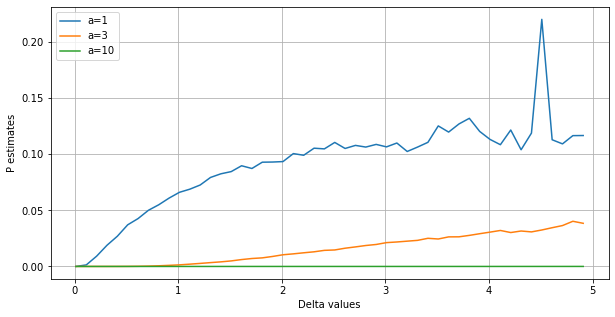

In [6]:
fig,ax = plt.subplots(1,figsize=(10,5))
ax.plot(delta,out_p_is,label=["a=1","a=3","a=10"])
ax.set_xlabel("Delta values")
ax.set_ylabel("P estimates")
plt.legend()
plt.grid()
plt.show()

## 2. Pricing of a Barrier option with antithetic variables

In [68]:
# Parameters
r = 0.5
sigma = 0.3
S_0 = 5
T = 2
K = 10
m = 1000
dt = T/m
N = 1000
M = int(N/2)
B = 2

W_mat = np.zeros((M,m))

# X_0 = 0 car 0 + sigma*W_0 = 0
#for i in range(M):
#    W_mat[i] =np.append([0],np.cumsum(np.sqrt(dt)*st.norm.rvs(size=m-1)))

W_mat = np.append(np.zeros((M,1)),np.cumsum(np.sqrt(dt)*st.norm.rvs(size=(M,m)),axis=1),axis=1)

print(W_mat.shape)
# Antithetic variables 
X_t = (r-sigma**2/2)*np.arange(0,T+dt,dt) + sigma*W_mat
X_t_rev = 2*(r-sigma**2/2)*np.arange(0,T+dt,dt)-X_t
S_t = S_0*np.exp(X_t)
S_t_rev = S_0*np.exp(X_t_rev)

#Payoff computation
Payoff = np.maximum(S_t[:,-1]-K,0)*(B<=np.min(S_t,axis=1))
Payoff_rev = np.maximum(S_t_rev[:,-1]-K,0)*(B<=np.min(S_t_rev,axis=1))
E_payoff = np.sum(Payoff+Payoff_rev)/N

# Voir correction pour savoir comment faire ces variables, car j'ai pas de correlation négative :/

(500, 1001)


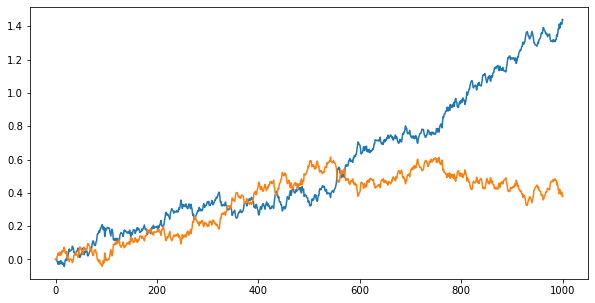

[[0.15659676 0.04384564]
 [0.04384564 0.03257394]]
[[ 1.         -0.57317398]
 [-0.57317398  1.        ]]
[[ 30.73821994 -16.86886332]
 [-16.86886332  28.17863745]]


In [69]:
plt.figure(figsize=(10,5))
plt.plot(X_t[0])
plt.plot(X_t_rev[0])
plt.show()
print(np.cov(X_t[0],X_t_rev[0]))
print(np.corrcoef(Payoff,Payoff_rev))
print(np.cov(Payoff,Payoff_rev))

## 3. Random walk with antithetic variables

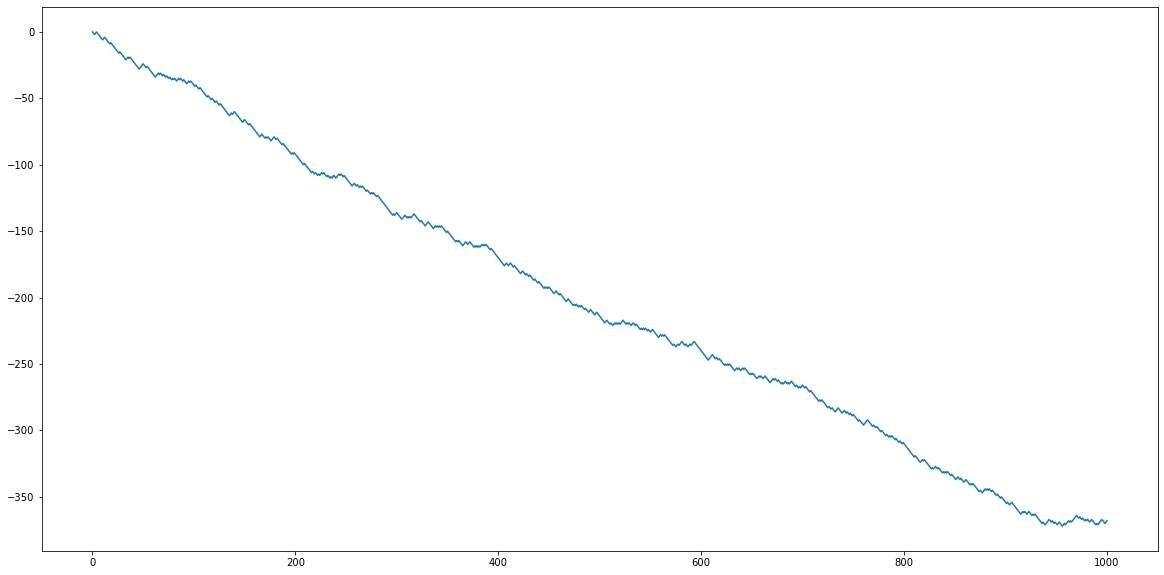

In [8]:
# Parameters
a = 1/3
K = 4
T = 10
n = 1000
X = np.zeros(n+1)

U = np.random.uniform(0.0,1.0,n)
for i,u in enumerate(U):
    if u<a:
        X[i+1] = X[i]+1
    else:
        X[i+1] = X[i]-1

fig, ax = plt.subplots(1,figsize=(20,10))
plt.plot(np.arange(n+1),X)
plt.show()

In [9]:
# MC
N = 1000
X_MC = np.zeros((N,n+1))
for idx in range(N):
    U = np.random.uniform(0.0,1.0,n)
    for i,u in enumerate(U):
        if u<a:
            X_MC[idx,i+1] = X[i]+1
        else:
            X_MC[idx,i+1] = X[i]-1

In [10]:
## Il pue leur K